# EXPLORATION 16

# 16. 흐린 사진을 선명하게

* Writier : 송영석
* Date : 2021.11.25

# 프로젝트 1-1

### 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

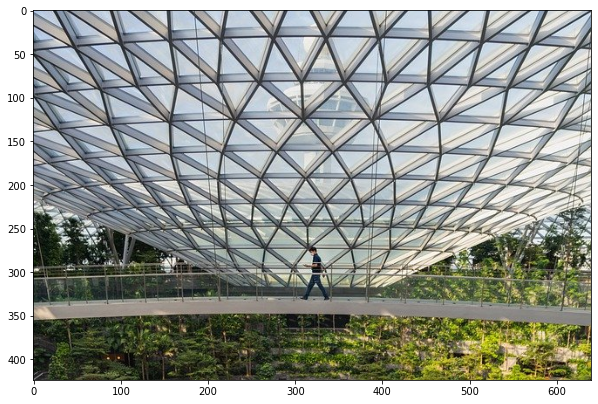

In [26]:
image_high = cv2.imread(os.getenv('HOME') + '/aiffel/LMS/super_resolution/고해상도.jpg')
image_high = cv2.cvtColor(image_high, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(image_high)

### 2.불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.

In [18]:
bicubic_image = cv2.resize(
    image_high, 
    dsize=(image_high.shape[1]//4, image_high.shape[0]//4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 

In [19]:
model_file =  os.getenv('HOME')+'/aiffel/LMS/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [20]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [21]:
srgan_hr = apply_srgan(bicubic_image)

### 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.

In [22]:
bicubic_hr = cv2.resize(
    bicubic_image, 
    dsize=(bicubic_image.shape[1]*4, bicubic_image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 

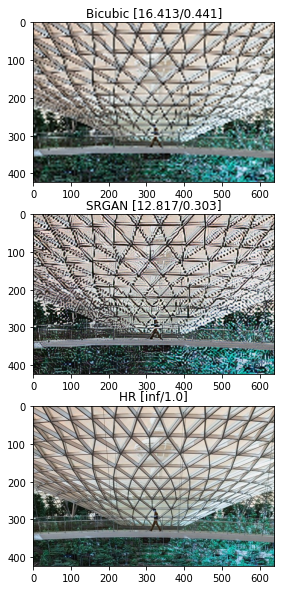

In [23]:
images = [bicubic_hr, srgan_hr, image_high]
titles = ["Bicubic", "SRGAN", "HR"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(image_high, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(image_high, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(16,10))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=12)

Text(0.5, 1.0, 'HR')

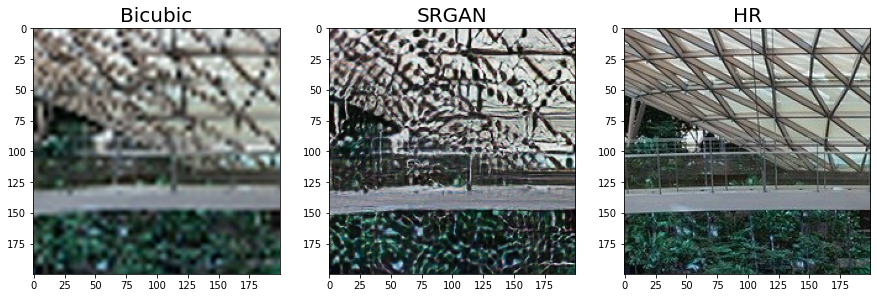

In [24]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 srgan 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (200, 100)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_srgan_hr = crop(srgan_hr, left_top)
crop_image = crop(image_high, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,3,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=20)
plt.subplot(1,3,2); plt.imshow(crop_srgan_hr); plt.title("SRGAN", fontsize=20)
plt.subplot(1,3,3); plt.imshow(crop_image); plt.title("HR", fontsize=20)

### 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. 

SRGAN이 생각보다 잘 되어지지 않았는데 원본이미지자체가 크기가 작았어서 그런것이 아닌가 생각하고 있습니다.(용량을 작게하여 upload 하기 위해)

# 프로젝트 1-2

### 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

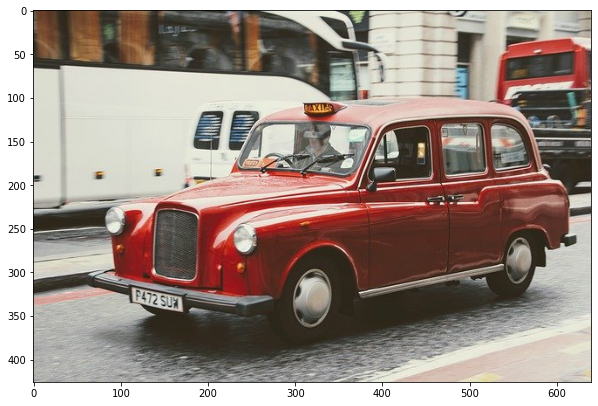

In [28]:
image_low = cv2.imread(os.getenv('HOME') + '/aiffel/LMS/super_resolution/저해상도.jpg')
image_low = cv2.cvtColor(image_low, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,8))
plt.imshow(image_low)

### 2.불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 

In [29]:
srgan_low = apply_srgan(image_low)

### 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.

In [30]:
bicubic_low = cv2.resize(
    image_low, 
    dsize=(image_low.shape[1]*4, image_low.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다.

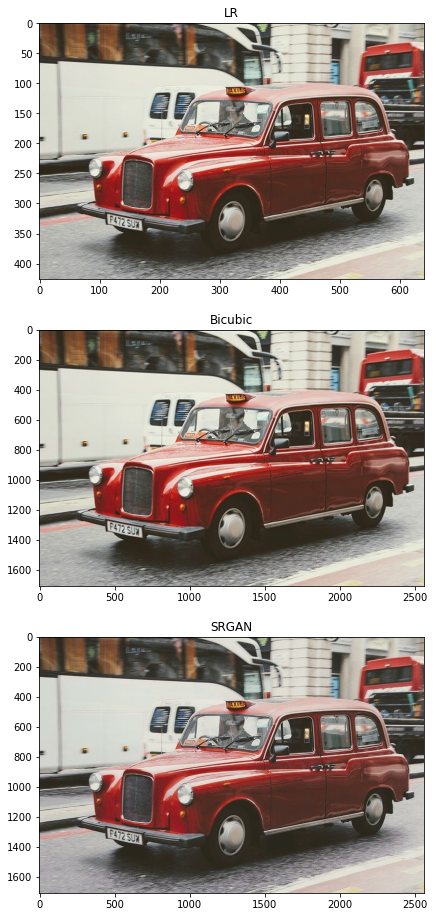

In [31]:
images = [image_low,bicubic_low, srgan_low]
titles = ["LR","Bicubic", "SRGAN"]


plt.figure(figsize=(16,16))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])

Text(0.5, 1.0, 'Bicubic')

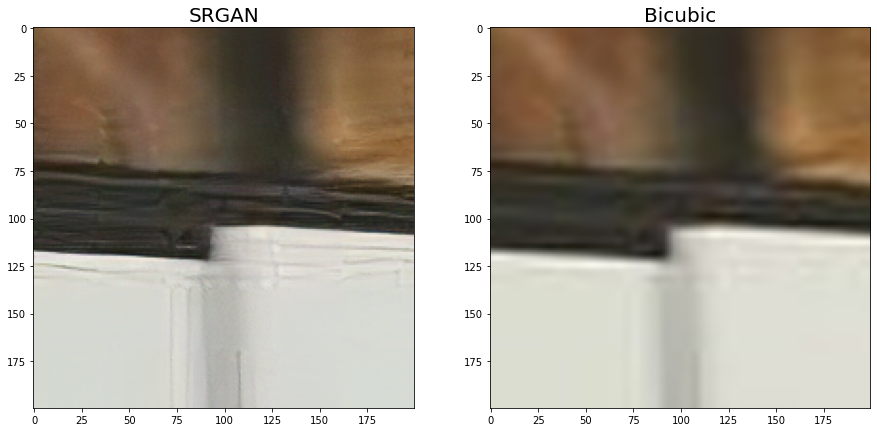

In [35]:
# interpolation된 이미지와 srgan 이미지와 저해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (150, 30)
crop_bicubic_low = crop(bicubic_low, left_top)
crop_srgan_low = crop(srgan_low, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,15))
plt.subplot(1,2,1); plt.imshow(crop_srgan_low); plt.title("SRGAN", fontsize=20)
plt.subplot(1,2,2); plt.imshow(crop_bicubic_low); plt.title("Bicubic", fontsize=20)

### 5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

큰 이미지에서는 전혀 차이가 없어 보였으나 확대를 해보니 확실히 SRGAN이미지가 더 잘 나타난 것을 알 수 있었습니다.


# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기


## 1. gif 파일 불러오기

In [39]:
gif_path = os.getenv('HOME') + '/aiffel/LMS/super_resolution/city_night_lr.gif'
gif = cv2.VideoCapture(gif_path)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


## 2. 프레임별 Super Resolution 진행하기

In [40]:
# Bicubic interpolation
Bicubic_frames = []
for frame in frames:
    bc = cv2.resize(
        frame,
        dsize = (frame.shape[1]*4, frame.shape[0]*4),
        interpolation = cv2.INTER_CUBIC
    )
    Bicubic_frames.append(bc)

In [41]:
frames_sr = []
for frame in frames:
    srgan_frame = apply_srgan(frame)
    frames_sr.append(srgan_frame)

## 3. 프레임을 합쳐 gif 만들기

In [45]:
import imageio
gif_path_save = os.getenv('HOME') + '/aiffel/LMS/super_resolution'
imageio.mimsave(os.path.join(gif_path_save, 'bicubic.gif'), Bicubic_frames)
imageio.mimsave(os.path.join(gif_path_save, 'srgan.gif'), frames_sr)

## 4. Jupyter notebook에 gif 표시하기

In [48]:
from IPython.display import Image as show_gif

### 1. Bicubic gif

show_gif(open(os.getenv('HOME') + '/aiffel/LMS/super_resolution/bicubic.gif','rb').read(), width=800)

### 2. SRGAN gif

show_gif(open(os.getenv('HOME') + '/aiffel/LMS/super_resolution/srgan.gif','rb').read(), width=800)

### 3. 원본 gif

show_gif(open(os.getenv('HOME') + '/aiffel/LMS/super_resolution/city_night_lr.gif','rb').read(), width=800)

파일크기가 커서 구글 드라이브 링크를 첨부드립니다.  
https://drive.google.com/drive/folders/1Ee_f2ePp49WYqy1tn8q7IhIt0u7gCJeV?usp=sharing


# 회고


1.gif에서는 일부를 따로 보지 않아서 큰 차이를 느끼기 어려웠습니다. (오히려 움직여서 더 큰 차이를 만들기 힘들었던것 같다.  
2. 고해상도 사진 1-1 프로젝트에서 SRGAN이 bicubic보다는 낫지만 큰 효과를 내지 못하고 여전히 사진의 quality가 낮은지 알아내지 못하였습니다. 